**STAT 685: Dr. Suojin Wang’s Group**

Modeling Seoul Bike Sharing Demand - 004 Description and Train/Test Split Methodology

Bai Zou, Nam Tran

# Description

The following is taken from the UCI website and was attached by the team that donated the data: 

*Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes.*

Based on the description above, we break it into two potential business requirements here:


* Predict next day hourly demand based on historical data until the current day.

* Real-time prediction for next hour demand based on historical data until the current hour. 


Point of interest:

* Prediction accuracy and variance for next day hourly demand on day X (M1).

* Prediction accuracy and variance, run time for next hour(Y+1) demand by training a new model with data updated to day X hour Y (M2).

* Prediction accuracy and variance, run time for next hour(Y+1) demand by continuous model training based M1 and updated data set from hour 1 to Y on day X (M3).

* Compare Prediction accuracy and run time between M2 and M3.



# Train/Test Split Methodology

The data set includes one year hourly bike rented count from Dec 2017 to Nov 2019. Splitting training and testing data in any anchor date will cause incomplete yearly distribution and information loss in training data. For example, there are only two days' observations for non-functional day before September 2018, which leaves little evidence for the model to identify the impact of Functional Day during training process if setting anchor date prior to September.

To minimize the information loss and maximize the training data size available, the testing anchor date and time will be set no earlier than November 1, 2018:
* Feature distributions are close to all year distribution
* Preliminary model testing shows the best result when using Nov 2018 data for testing. (Report 3, section Model Tested with Anchor Date)

Testing data set:

* Randomly select n(5 - 10 depends on run time) days as anchor days from Nov 2018.
    * For each anchor day, all observations prior to this anchor day is considered as training data.
    * For each anchor day, the next 24 hour observations is considered as testing data for M1.
    * There are n sets of training and testing data sets.
* Each anchor day selected above will have 24 sets of training and testing data based on anchor hour (M2 & M3).
* Or randomly select m anchor hours for each anchor day selected above (if run time becomes a consideration). 
    


## Feature Distribution
The tables and plots below are comparing distributions of each feature for all observations and observations before November 1, 2018. In general, the data set prior to November 2018 has a close enough distribution in all features compare with the one year data set.

In [38]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
## load data
fn = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), './data/SeoulBikeData.csv'))
colNames = ["Date", "RentedBikeCount", "Hour", "Temp", "Humidity", "WindSpeed", "Visibility", 
            "DewPointTemp", "SolarRadiation","Rainfall", "Snowfall", "Seasons", "Holiday", "FunctionalDay"]
dat = pd.read_csv(fn, encoding="ISO-8859-1")
dat.columns = colNames
dat = dat.astype(
    {"Date": str, 
    "RentedBikeCount": int, 
    "Hour": float, 
    "Temp": float, 
    "Humidity": float,
    "WindSpeed": float, 
    "Visibility": float, 
    "DewPointTemp": float, 
    "SolarRadiation": float,
    "Rainfall": float, 
    "Snowfall": float, 
    "Seasons": str, 
    "Holiday": str, 
    "FunctionalDay": str})
dat['Date'] = pd.to_datetime(dat['Date'], format="%d/%m/%Y")

In [40]:
%%capture
# data prior to last three month
compare_dat = dat.copy()
compare_dat['DataSet'] = "all_year"
data_set = {'all_year': dat}
for mo in [9, 10, 11]:
    sub_dat = dat[(dat['Date'].dt.month < mo)|(dat['Date'].dt.year == 2017)]
    sub_dat.loc[:, 'DataSet']= f"before_mo{mo}"
    compare_dat = compare_dat.append(sub_dat)
    data_set[f"before_mo{mo}"] = sub_dat

In [4]:
pd.DataFrame({k: v['Holiday'].value_counts(normalize=True) for k, v in data_set.items()}).round(2)

,all_year,before_mo9,before_mo10,before_mo11
No Holiday,0.95,0.95,0.95,0.95
Holiday,0.05,0.05,0.05,0.05


In [5]:
pd.DataFrame({k: v['FunctionalDay'].value_counts(normalize=True) for k, v in data_set.items()}).round(2)

,all_year,before_mo9,before_mo10,before_mo11
Yes,0.97,0.99,0.98,0.97
No,0.03,0.01,0.02,0.03


In [6]:
pd.DataFrame({k: v['Seasons'].value_counts(normalize=True) for k, v in data_set.items()}).round(2)

,all_year,before_mo9,before_mo10,before_mo11
Autumn,0.25,NaN,0.1,0.18
Spring,0.25,0.34,0.3,0.27
Summer,0.25,0.34,0.3,0.27
Winter,0.25,0.33,0.3,0.27


In [37]:
def plot_dist_compare(feature):
    f, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
    for i in range(3):
        sns.histplot(compare_dat[compare_dat['DataSet'].isin(['all_year', f'before_mo{i+9}'])], 
                     x=feature, hue="DataSet", stat="probability", ax=axes[i], element="step")

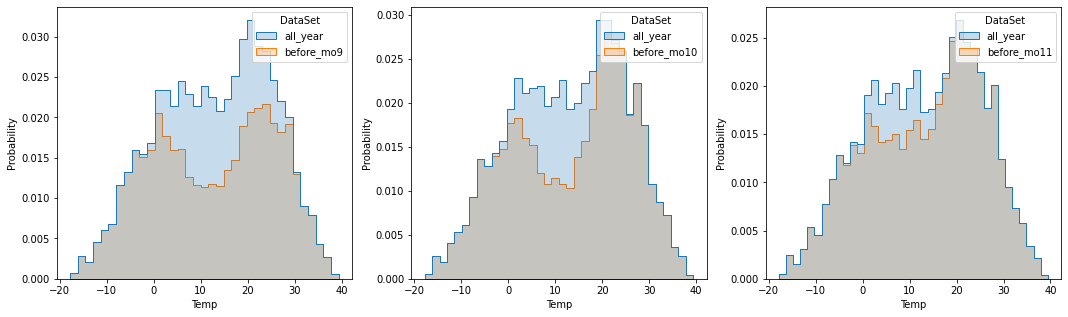

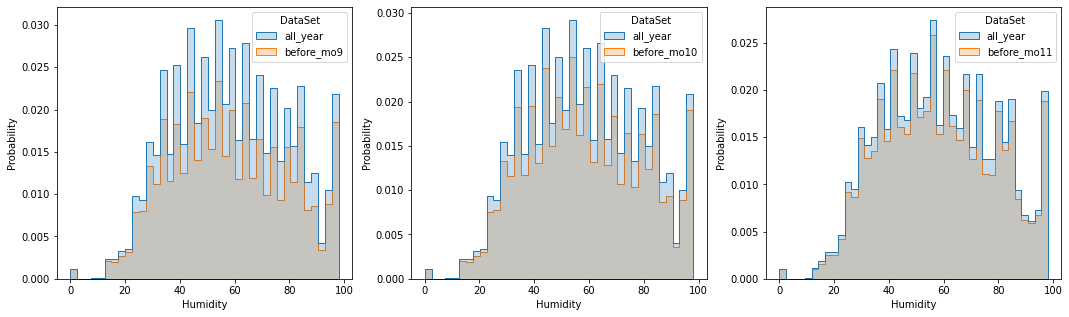

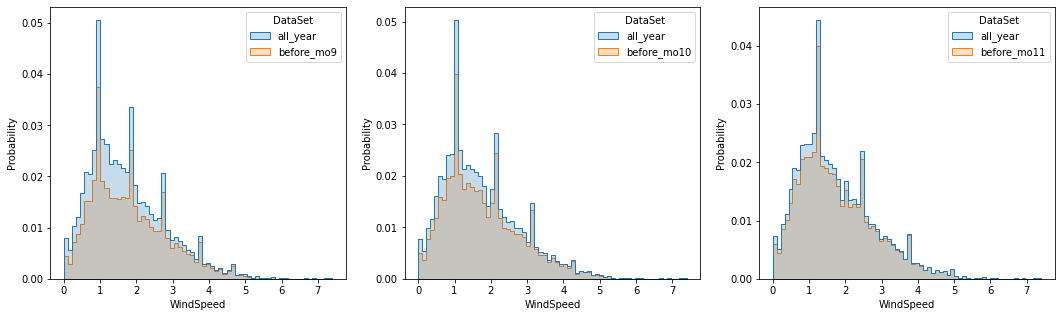

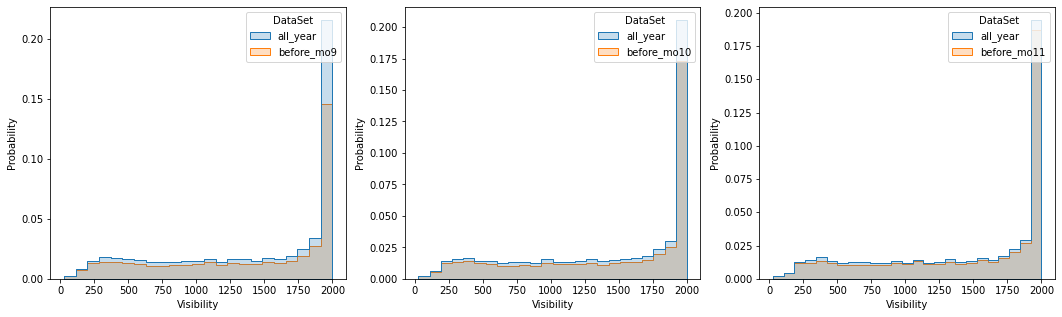

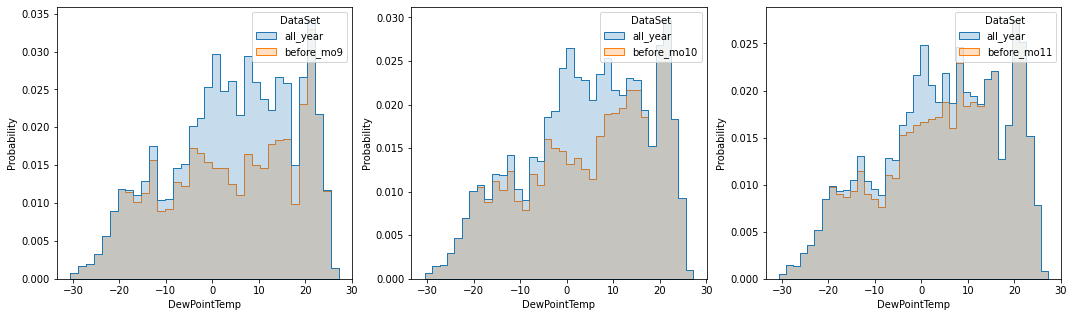

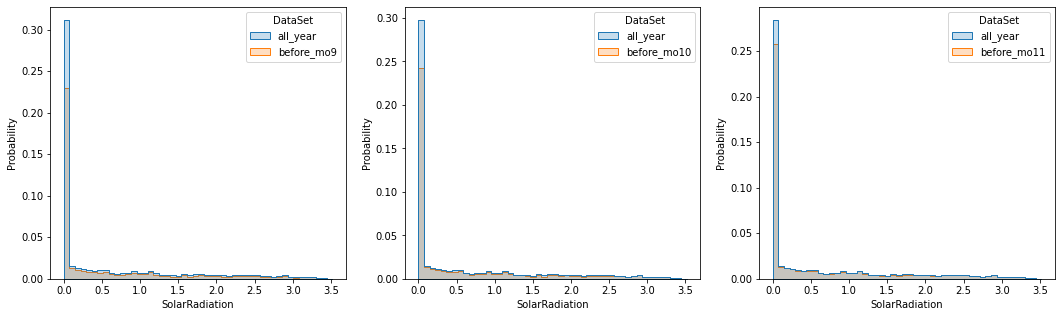

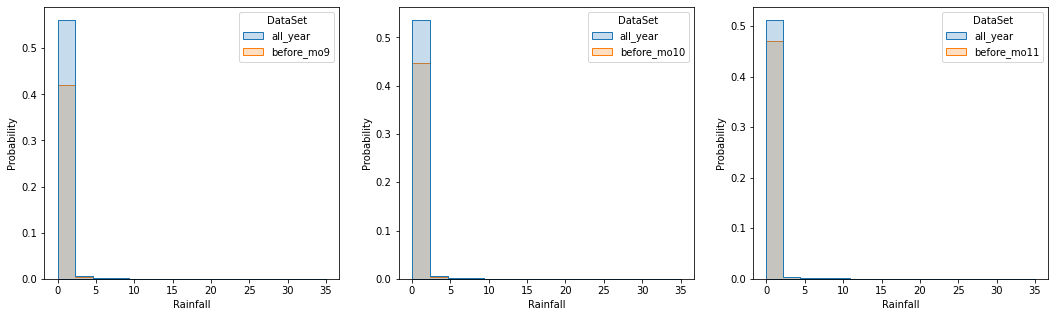

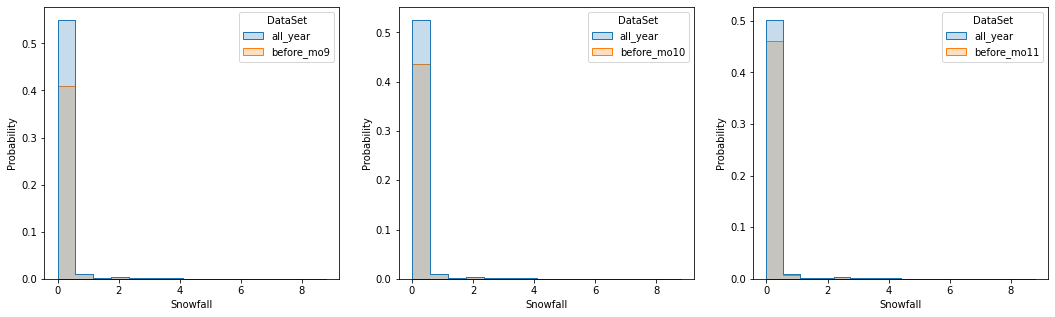

In [36]:
for col in ["Temp", "Humidity", "WindSpeed", "Visibility", "DewPointTemp", "SolarRadiation", "Rainfall", "Snowfall"]:
    plot_dist_compare(col)